[View in Colaboratory](https://colab.research.google.com/github/scon012/722-Iteration-4/blob/master/722_Iteration_4_Google.ipynb)

In [0]:
# For AWS
# Section must be included at the beginning of each new notebook. Remember to change the app name. 
# If you're using VirtualBox, change the below to '/home/user/spark-2.1.1-bin-hadoop2.7'
#import findspark
#findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
#import pyspark
#from pyspark.sql import SparkSession
#spark = SparkSession.builder.appName('missing').getOrCreate()



In [49]:
# For Google Step 1
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/spark-2.2.2/spark-2.2.2-bin-hadoop2.7.tgz
!tar xf spark-2.2.2-bin-hadoop2.7.tgz
!pip install -q findspark

# Install Pydrive so that the data files can be got from GoogleDrive
!pip install PyDrive

# Install R and required components
# !apt-get update
# !apt-get install r-base
# !pip install rpy2==2.9.4
# !pip install tzlocal




Redirecting output to ‘wget-log.3’.


In [0]:
# Test that rpy2 works
#import rpy2.tests as rpt
#import unittest
#import rpy2.interactive as r

# from rpy2 import robjects
# import rpy2.robjects as robjects
# robjects.r('library(ade4)')

# # the verbosity level can be increased if needed
# tr = unittest.TextTestRunner(verbosity = 1)
# suite = rpy2.tests.suite()
# tr.run(suite)

#from rpy2.robjects import r, pandas2ri
#from rpy2.robjects.packages import importr
#import rpy2.robjects as ro

# ro.r('install.packages("ggplot2")')

# ro.r('x=c()')
# ro.r('x[1] = 1 + 2')
# ro.r('x[3] = 1 + 77')
# x = pandas2ri.ri2py(r['x'])
# print(ro.r('x'))
# print(x)


In [0]:
# For Google Step 2
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.2.2-bin-hadoop2.7"

In [0]:
# For Google Step 3
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

######################################################################################################
### Configure the environment
######################################################################################################

In [0]:
# Other environment imports
from pyspark.sql.functions import datediff, to_date, lit, when, date_sub, col, isnan, count, abs
from pyspark.ml.feature import ChiSqSelector, VectorAssembler, VectorIndexer, OneHotEncoder, StringIndexer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

######################################################################################################
### Get and inspect the data
######################################################################################################

In [0]:
# Clean up the old data
# !ls -al
# !rm "2016-17_standings.csv"
# !rm "2017-18_standings.csv"
# !rm "2016-17_teamBoxScore.csv"
# !rm "2017-18_teamBoxScore.csv"
# !ls -al

#############################################################
# Get the data for Colab from the local file system

# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

#############################################################
# Get the data from Google Drive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()

# Download the basketball files
standings1617fileID = '1zP8Ua8NGlhYAkEaACXFMvEeLh8rQ2Jtq'
standings1718fileID = '1XfyfvX-hiI4KcERgLsDsgE1C7_hbgfIC'
boxScore1617fielID = '1bahfh1jOp9brP4CnGg_lywxvjyfmTIMT'
boxScore1718fielID = '1R3jEED7ME4voFajkzAK_IsZM_MGINF8P'

gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Get the data files on Colab
def getGoogleFile(fileId, filename):
  train_downloaded = drive.CreateFile({'id': fileId})
  train_downloaded.GetContentFile(filename)
  return

dummy = getGoogleFile(standings1617fileID, "2016-17_standings.csv")
dummy = getGoogleFile(standings1718fileID, "2017-18_standings.csv")
dummy = getGoogleFile(boxScore1617fielID, "2016-17_teamBoxScore.csv")
dummy = getGoogleFile(boxScore1718fielID, "2017-18_teamBoxScore.csv")


In [225]:
# Get the data files on AWS
standings1617 = spark.read.csv("2016-17_standings.csv", header=True, inferSchema=True)
standings1617.show(5)

standings1718 = spark.read.csv("2017-18_standings.csv", header=True, inferSchema=True)
standings1718.show(5)

boxScore1617 = spark.read.csv("2016-17_teamBoxScore.csv", header=True, inferSchema=True)
boxScore1617.show(5)

boxScore1718 = spark.read.csv("2017-18_teamBoxScore.csv", header=True, inferSchema=True)
boxScore1718.show(5)


+-------------------+--------+----+-------+-------+--------+---+-------+------+--------+------+--------+-------+--------+-------+--------+-------+--------+--------+-------+--------+--------+--------+-------+----------+---------+--------------+-------------+---+-----------+---+---+------+------------+---------+---------+-----------+--------+--------+
|             stDate|teamAbbr|rank|rankOrd|gameWon|gameLost|stk|stkType|stkTot|gameBack|ptsFor|ptsAgnst|homeWin|homeLoss|awayWin|awayLoss|confWin|confLoss|lastFive|lastTen|gamePlay|ptsScore|ptsAllow|ptsDiff|opptGmPlay|opptGmWon|opptOpptGmPlay|opptOpptGmWon|sos|relPercIndx|mov|srs|pwPerc|pythPerc1391|wpyth1391|lpyth1391|pythPerc165|wpyth165|lpyth165|
+-------------------+--------+----+-------+-------+--------+---+-------+------+--------+------+--------+-------+--------+-------+--------+-------+--------+--------+-------+--------+--------+--------+-------+----------+---------+--------------+-------------+---+-----------+---+---+------+--------

In [55]:
# Update NULL values
# Date: 2017-12-28
# Third Official: Petraitis	Gediminas 

# Show the Null values in each of the dataframes
boxScore1617.filter('IsNull(offFNm3)').show()
boxScore1718.filter('IsNull(offFNm3)').show()

# Show the null values
boxScore1718.filter('IsNull(offFNm3)').select("offLNm3", "offFNm3").show()

# Replace the nulls
boxScore1718 = boxScore1718.na.fill({'offLNm3' : "Gediminas", 'offFNm3' : "Petraitis" })

# Show that there are no more null values
boxScore1718.filter('IsNull(offFNm3)').select("offLNm3", "offFNm3").show()

# Show that the Null values in the 1718 dataframes have gone
boxScore1718.filter('IsNull(offFNm3)').show()


+------+------+-------+-------+-------+-------+-------+-------+-------+--------+--------+-------+-------+--------+-------+----------+-------+-------+------+-------+-------+------+-------+-------+----------+-------+-------+----------+-------+-------+----------+-------+-------+----------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+------------+------------+----------+-----------+------------+------------+----------+-----------+-----------+--------+-------+-------+---------+--------+--------+---------+------------+------+---------+---------+--------+--------+-------+-------+--------+-------+----------+-------+-------+------+-------+-------+------+-------+-------+----------+-------+-------+----------+-------+-------+----------+-------+-------+----------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+------------+------------+----------+-----------+------------+------------+----------+------

######################################################################################################
### For the Box Score preparation - the next set of steps are for the box score data preparation
######################################################################################################

In [56]:
# Create column for the "days since" the start of the season for 2016/17

boxScore1617 = boxScore1617.withColumn('daysSince', datediff(to_date(boxScore1617['gmDate']), to_date(lit('2016-10-25'))))
boxScore1617.show(5)

+-------------------+------+-------+-------+-------+--------+-------+--------+-------+--------+--------+---------+-------+--------+-------+----------+-------+-------+------+-------+-------+------+-------+-------+----------+-------+-------+----------+-------+-------+----------+-------+-------+----------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+------------+------------+----------+-----------+------------+------------+----------+-----------+-----------+--------+-------+-------+---------+--------+--------+---------+------------+-------+---------+---------+--------+--------+---------+-------+--------+-------+----------+-------+-------+------+-------+-------+------+-------+-------+----------+-------+-------+----------+-------+-------+----------+-------+-------+----------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+------------+------------+----------+-----------+------------+----------

In [57]:
# Create column for the "days since" the start of the season for 2017/18

boxScore1718 = boxScore1718.withColumn('daysSince', datediff(to_date(boxScore1718['gmDate']), to_date(lit('2016-10-17'))))
boxScore1718.show(5)

+-------------------+------+-------+-------+-------+---------+-------+---------+-------+--------+--------+---------+-------+--------+-------+----------+-------+-------+------+-------+-------+------+-------+-------+----------+-------+-------+----------+-------+-------+----------+-------+-------+----------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+------------+------------+----------+-----------+------------+------------+----------+-----------+-----------+--------+-------+-------+---------+--------+--------+---------+------------+-------+---------+---------+--------+--------+---------+-------+--------+-------+----------+-------+-------+------+-------+-------+------+-------+-------+----------+-------+-------+----------+-------+-------+----------+-------+-------+----------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+------------+------------+----------+-----------+------------+--------

In [58]:
# Merge the two years dataframes of Games Played data
boxScoreAll = boxScore1617.union(boxScore1718)

print("Box Score 1617:", boxScore1617.count())
print("Box Score 1718:", boxScore1718.count())
print("Box Score All:", boxScoreAll.count())

Box Score 1617: 2460
Box Score 1718: 2460
Box Score All: 4920


In [59]:
# Remove all the "Away" perspective records by selecting only the "Home" records
boxScoreAll = boxScoreAll.filter('teamLoc = "Home"')
print("Box Score All:", boxScoreAll.count())

Box Score All: 2460


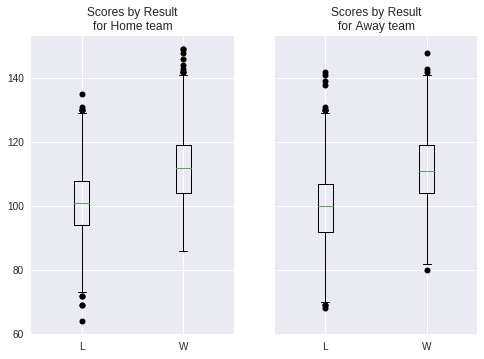

In [61]:
# Visualize the Outliers

myBS = pd.DataFrame(boxScoreAll.take(5000))

plotData = pd.DataFrame(myBS, columns = [13, 16]).rename(inplace=False, index = str, columns = {13:"teamRslt",16:'teamPTS'}).pivot(columns='teamRslt')

# Remove the NaN values from the array and make into a list because they will not be the same length
plotdata = np.array(plotData)
mask = ~np.isnan(plotdata)
plotdata = [d[m] for d, m in zip(plotdata.T, mask.T)]

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)
axes[0].boxplot(plotdata, showfliers = True, labels=list('LW'), sym='k')
axes[0].set_title("Scores by Result\nfor Home team")

# Repeat again for the away team
plotData = pd.DataFrame(myBS, columns = [69, 72]).rename(inplace=False, index = str, columns = {69:"teamRslt",72:'teamPTS'}).pivot(columns='teamRslt')
plotdata = np.array(plotData)
mask = ~np.isnan(plotdata)
plotdata = [d[m] for d, m in zip(plotdata.T, mask.T)]

axes[1].boxplot(plotdata, showfliers = True, labels=list('LW'), sym='k')
axes[1].set_title("Scores by Result\nfor Away team")

fig.subplots_adjust(hspace=50)
plt.show()

In [295]:
# Compare Home Win/Loss record with scatterplot
boxScoreAll = boxScoreAll.withColumn('teamPTSDiff', abs(boxScoreAll['teamPTS'] - boxScoreAll['opptPTS']))

pdDataFrame = pd.DataFrame(boxScoreAll.toPandas())

cdict = {'Loss': 'red', 'Win': 'green'}
fig, ax = plt.subplots()
for g in np.unique(pdDataFrame.teamRslt):
    ax.scatter(pdDataFrame.teamPTSDiff[pdDataFrame.teamRslt == g], pdDataFrame.teamPTS[pdDataFrame.teamRslt == g], c = cdict[g], label = g, s = 50)
plt.legend(loc='best', bbox_to_anchor=(0.5, 0., 0.5, 0.5), frameon = True, edgecolor = "black")
plt.title('Points differential in Wins vs Losses')
plt.ylabel('Home Points')
plt.xlabel('Absolute Points Differential')
plt.show()

AnalysisException: ignored

In [285]:
# Remove the columns that are not known before the game starts by selecting the columns that do. seasTyp is also removed because it is the same for all games 'Regular' - for regular season"
print("Number of rows with 'seasTyp == Regular':", boxScoreAll.filter('seasTyp == "Regular"').count()) # Shows 2460 which is the number of records
print("Number of rows with 'teamLoc == Home':", boxScoreAll.filter('teamLoc == "Home"').count()) # Shows 2460 which is the number of records
print("Number of rows with 'opptLoc == Away':", boxScoreAll.filter('opptLoc == "Away"').count()) # Shows 2460 which is the number of records

# Show that the first name last combinations is the same as the last names on their own. Therefore, the firstname feature does not add any value and is removed
print("Lastnames:", len(np.unique(pdDataFrame.offLNm1)))
print("Firstnames:", len(np.unique(pdDataFrame.offFNm1)))
print("Lastnames and Firstnames:", len(np.unique(pdDataFrame.offLNm1 + pdDataFrame.offLNm1)))

print("Lastnames:", len(np.unique(pdDataFrame.offLNm2)))
print("Firstnames:", len(np.unique(pdDataFrame.offFNm2)))
print("Lastnames and Firstnames:", len(np.unique(pdDataFrame.offLNm2 + pdDataFrame.offLNm2)))

print("Lastnames:", len(np.unique(pdDataFrame.offLNm3)))
print("Firstnames:", len(np.unique(pdDataFrame.offFNm3)))
print("Lastnames and Firstnames:", len(np.unique(pdDataFrame.offLNm3 + pdDataFrame.offLNm3)))

boxScoreAll = boxScoreAll.select('gmDate','gmTime','offLNm1','offLNm2','offLNm3','teamAbbr','teamConf','teamDiv','teamRslt','teamDayOff','opptAbbr','opptConf','opptDiv','opptDayOff','daysSince')
boxScoreAll.show(5)

Number of rows with 'seasTyp == Regular': 2460
Number of rows with 'teamLoc == Home': 2460
Number of rows with 'opptLoc == Away': 2460
Lastnames: 58
Firstnames: 53
Lastnames and Firstnames: 58
Lastnames: 62
Firstnames: 54
Lastnames and Firstnames: 62
Lastnames: 62
Firstnames: 58
Lastnames and Firstnames: 62
+-------------------+------+--------+--------+----------+--------+--------+---------+-------+--------+----------+--------+--------+---------+-------+----------+---------+
|             gmDate|gmTime| offLNm1| offLNm2|   offLNm3|teamAbbr|teamConf|  teamDiv|teamLoc|teamRslt|teamDayOff|opptAbbr|opptConf|  opptDiv|opptLoc|opptDayOff|daysSince|
+-------------------+------+--------+--------+----------+--------+--------+---------+-------+--------+----------+--------+--------+---------+-------+----------+---------+
|2016-10-25 00:00:00| 08:00|    Lane|   Adams|   Kennedy|     CLE|    East|  Central|   Home|     Win|         0|      NY|    East| Atlantic|   Away|         0|        0|
|2016-1

In [64]:
# Fix the rows that have the wrong times - they need 12hr deducted from their times
boxScoreAll.filter('gmTime > "12:30"').select('gmtime').show()

boxScoreAll = boxScoreAll.withColumn("gmTime", when(boxScoreAll["gmTime"] > '12:30', boxScoreAll["gmTime"] - '12:00').otherwise(boxScoreAll["gmTime"]))

boxScoreAll.filter('gmTime > "12:30"').select('gmtime').show()

+------+
|gmtime|
+------+
| 18:00|
| 18:00|
| 19:00|
| 19:00|
+------+

+------+
|gmtime|
+------+
+------+



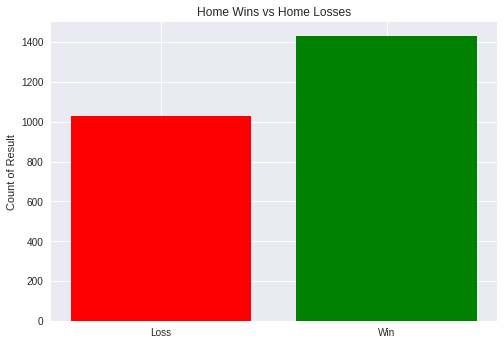

In [109]:
# Compare Home Win/Loss record with bar graph
pdDataFrame = boxScoreAll.toPandas()
objects = np.unique(pdDataFrame.teamRslt)
y_pos = np.arange(len(objects))

counts = [len(pdDataFrame[pdDataFrame['teamRslt'] == "Loss"]), len(pdDataFrame[pdDataFrame['teamRslt'] == "Win"])]
p1 = plt.bar(y_pos, counts, color = ['red', 'green'])

plt.ylabel('Count of Result')
plt.title('Home Wins vs Home Losses')
plt.xticks(y_pos, ('Loss', 'Win'))

plt.show()


######################################################################################################
### For the Standings preparation - the next set of steps are for the standings data preparation
######################################################################################################

In [321]:
# Join the two years datasets
standingsAll = standings1617.union(standings1718)
standingsAll.show(1)

# Rename the 'teamAbbr' column to prevent clash later
standingsAll = standingsAll.withColumnRenamed('teamAbbr', 'steamAbbr')
standingsAll.show(1)

print("Standings 1617:", standings1617.count())
print("Standings 1718:", standings1718.count()) 
# There are more standings rows in the 17/18 dataset because the season runs for a week longer
print("Standings All:", standingsAll.count())

# Drop the rankOrd column because it duplicates the rank column, also the stk because this is a duplicate of the stkType and stkTot columns
standingsAll = standingsAll.drop('rankOrd')
standingsAll = standingsAll.drop('stk')
standingsAll.show(10)

+-------------------+--------+----+-------+-------+--------+---+-------+------+--------+------+--------+-------+--------+-------+--------+-------+--------+--------+-------+--------+--------+--------+-------+----------+---------+--------------+-------------+---+-----------+---+---+------+------------+---------+---------+-----------+--------+--------+
|             stDate|teamAbbr|rank|rankOrd|gameWon|gameLost|stk|stkType|stkTot|gameBack|ptsFor|ptsAgnst|homeWin|homeLoss|awayWin|awayLoss|confWin|confLoss|lastFive|lastTen|gamePlay|ptsScore|ptsAllow|ptsDiff|opptGmPlay|opptGmWon|opptOpptGmPlay|opptOpptGmWon|sos|relPercIndx|mov|srs|pwPerc|pythPerc1391|wpyth1391|lpyth1391|pythPerc165|wpyth165|lpyth165|
+-------------------+--------+----+-------+-------+--------+---+-------+------+--------+------+--------+-------+--------+-------+--------+-------+--------+--------+-------+--------+--------+--------+-------+----------+---------+--------------+-------------+---+-----------+---+---+------+--------

##################################################################################
### Merge the standings data into the box score data
##################################################################################

In [111]:
# Home team data
boxWithStand = boxScoreAll.join(standingsAll, (boxScoreAll.teamAbbr == standingsAll.steamAbbr) & (date_sub(boxScoreAll.gmDate, 1) == to_date(standingsAll.stDate)))

# Confirm that the counts are the same
print(boxScoreAll.count())
print(boxWithStand.count())

2460
2460


In [112]:
# Away team data

# Rename columns by adding a suffix so that there are no name clashes
opptStandings = standingsAll.select(*(col(x).alias(x + '_oppt') for x in standingsAll.columns))

# Join the tables
boxWithStand = boxWithStand.join(opptStandings, (boxScoreAll.opptAbbr == opptStandings.steamAbbr_oppt) & (date_sub(boxScoreAll.gmDate, 1) == to_date(opptStandings.stDate_oppt)))

# Confirm that the counts are the same
print(boxScoreAll.count())
print(boxWithStand.count())


2460
2460


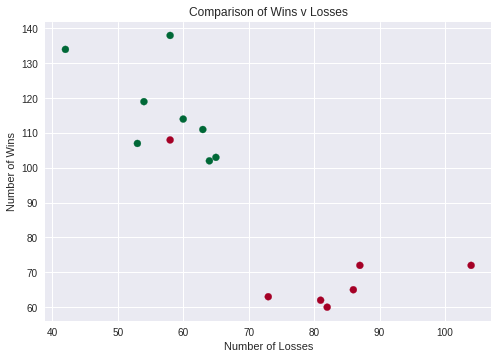

In [302]:
from matplotlib import cm

# Compare Win/Loss record with rank

# Prepare the data
pdDataFrame = boxWithStand.toPandas()

# Build up the dataset required for plotting

resultsDf = pd.DataFrame(columns = ['rank', 'Win', 'Loss'])
resultsDf = resultsDf.fillna(0) # with 0s rather than NaNs

for i in range(1, 16):
  df = pdDataFrame.groupby(['rank', 'teamRslt']).get_group((i, 'Win')).aggregate('count')
  df2 = pdDataFrame.groupby(['rank', 'teamRslt']).get_group((i, 'Loss')).aggregate('count')
  vals = { 'rank' : i, 'Win' : df[0], 'Loss' : df2[0]}
  
  newDF = pd.DataFrame(vals, index=[0])
  resultsDf = resultsDf.append(newDF)
  
plt.scatter(resultsDf['Loss'], resultsDf['Win'], c = resultsDf['rank'] < 9, cmap = cm.RdYlGn)
plt.title("Comparison of Wins v Losses")
plt.xlabel("Number of Losses")
plt.ylabel("Number of Wins")
plt.show()


##################################################################################

Split the data and prepare for Machine Learning
##################################################################################

In [325]:
##############
# Training data - get all the rows that are pre 2018-01-01

trainingData = boxWithStand.filter('gmDate < "2018-01-01"')
print(trainingData.count())

# Remove the gmDate column - It is no longer required because we have the calculated daysSince column. It was only required to get Training and Test data
trainingData = trainingData.drop('gmDate')

1774


In [326]:
##############
# Test data - get all the rows that are between 2018-01-01 and 2018-02-07

testData = boxWithStand.filter('gmDate >= "2018-01-01" AND gmDate <= "2018-02-07"')
print(testData.count())

# Remove the gmDate column - It is no longer required because we have the calculated daysSince column. It was only required to get Training and Test data
testData = testData.drop('gmDate')

260


In [345]:
##############
# OneHot the categorical variables so that feature selection and algorithms can be run

# Indexers for Standings Columns
teamAbbr_indexer = StringIndexer(inputCol='teamAbbr',outputCol='teamAbbrIndex')
stkType_indexer = StringIndexer(inputCol='stkType',outputCol='stkTypeIndex')

# Box Score columns
gmTime_indexer = StringIndexer(inputCol='gmTime',outputCol='gmTimeIndex')
offLNm1_indexer = StringIndexer(inputCol='offLNm1',outputCol='offLNm1Index')
offLNm2_indexer = StringIndexer(inputCol='offLNm2',outputCol='offLNm2Index')
offLNm3_indexer = StringIndexer(inputCol='offLNm3',outputCol='offLNm3Index')
teamConf_indexer = StringIndexer(inputCol='teamConf',outputCol='teamConfIndex')
teamDiv_indexer = StringIndexer(inputCol='teamDiv',outputCol='teamDivIndex')
opptAbbr_indexer = StringIndexer(inputCol='opptAbbr',outputCol='opptAbbrIndex')
opptConf_indexer = StringIndexer(inputCol='opptConf',outputCol='opptConfIndex')
opptDiv_indexer = StringIndexer(inputCol='opptDiv',outputCol='opptDivIndex')
teamRslt_indexer = StringIndexer(inputCol='teamRslt',outputCol='rslt')

# Encoders for Standings Columns
teamAbbr_encoder = OneHotEncoder(inputCol='teamAbbrIndex',outputCol='teamAbbrVec')
stkType_encoder = OneHotEncoder(inputCol='stkTypeIndex',outputCol='stkTypeVec')

# Box Score columns
gmTime_encoder = OneHotEncoder(inputCol='gmTimeIndex',outputCol='gmTimeVec')
offLNm1_encoder = OneHotEncoder(inputCol='offLNm1Index',outputCol='offLNm1Vec')
offLNm2_encoder = OneHotEncoder(inputCol='offLNm2Index',outputCol='offLNm2Vec')
offLNm3_encoder = OneHotEncoder(inputCol='offLNm3Index',outputCol='offLNm3Vec')
teamConf_encoder = OneHotEncoder(inputCol='teamConfIndex',outputCol='teamConfVec')
teamDiv_encoder = OneHotEncoder(inputCol='teamDivIndex',outputCol='teamDivVec')
opptAbbr_encoder = OneHotEncoder(inputCol='opptAbbrIndex',outputCol='opptAbbrVec')
opptConf_encoder = OneHotEncoder(inputCol='opptConfIndex',outputCol='opptConfVec')
opptDiv_encoder = OneHotEncoder(inputCol='opptDivIndex',outputCol='opptDivVec')

# Gather the fields back together with the categorical columns replaced with OneHotted vectors
assembler = VectorAssembler(inputCols=['teamAbbrVec','stkTypeVec'
                                       , 'offLNm1Vec','offLNm2Vec','offLNm3Vec','teamConfVec','teamDivVec','opptAbbrVec','opptConfVec','opptDivVec'
                                       , 'gmTimeVec', 'pwPerc', 'mov_oppt', 'pythPerc1391', 'opptOpptGmPlay', 'ptsScore_oppt', 'wpyth1391_oppt'
                                       , 'gameLost', 'relPercIndx', 'mov', 'gamePlay_oppt', 'opptOpptGmWon', 'gameBack', 'sos', 'pwPerc_oppt'
                                       , 'wpyth165_oppt', 'lpyth1391_oppt', 'stkTot', 'awayWin_oppt', 'sos_oppt', 'srs', 'confLoss_oppt'
                                       , 'gameWon', 'lastTen', 'homeWin', 'srs_oppt', 'wpyth165', 'wpyth1391', 'ptsAllow_oppt'
                                       , 'ptsFor', 'lpyth165_oppt', 'confWin', 'homeWin_oppt'
                                       , 'homeLoss', 'confWin_oppt', 'opptGmPlay', 'ptsAllow'
                                       , 'relPercIndx_oppt', 'homeLoss_oppt', 'awayWin', 'teamDayOff', 'lpyth165'
                                       , 'opptDayOff', 'rank_oppt', 'ptsScore', 'ptsAgnst', 'ptsDiff_oppt'
                                       , 'lastFive', 'pythPerc1391_oppt', 'pythPerc165', 'ptsAgnst_oppt', 'stkTot_oppt', 'daysSince'
                                       , 'pythPerc165_oppt', 'gameLost_oppt', 'awayLoss', 'gameBack_oppt', 'awayLoss_oppt', 'lastFive_oppt'
                                       , 'lastTen_oppt', 'rank', 'gameWon_oppt', 'opptGmPlay_oppt', 'lpyth1391', 'opptGmWon_oppt'
                                       , 'ptsDiff', 'gamePlay', 'opptGmWon', 'opptGmPlay_oppt', 'ptsFor_oppt', 'confLoss'
                                      ], outputCol="features")

# Build the pipeline
pipeline = Pipeline(stages=[gmTime_indexer, teamAbbr_indexer, stkType_indexer
                            ,offLNm1_indexer, offLNm2_indexer,offLNm3_indexer, teamConf_indexer, teamDiv_indexer, opptAbbr_indexer, opptConf_indexer, opptDiv_indexer
                            ,teamRslt_indexer
                            ,offLNm1_encoder, offLNm2_encoder,offLNm3_encoder, teamConf_encoder, teamDiv_encoder, opptAbbr_encoder, opptConf_encoder, opptDiv_encoder
                            ,gmTime_encoder,teamAbbr_encoder, stkType_encoder
                            , assembler])

# Apply to the dataframe
pipeline_model = pipeline.fit(trainingData)

# Create the new dataframe
pipe_df = pipeline_model.transform(trainingData)

# Remove all variables other than features and label
pipe_df = pipe_df.select('rslt', 'features')
pipe_df.head(10)


Column<b'features'>


In [357]:
# # Convert to a dense vector
# from pyspark.ml.linalg import SparseVector, DenseVector
# # pipe_dense = pipe_df.map(lambda vector: DenseVector(vector.toArray()))
# # pipe_dense.head(10)
# print(pipe_df.select('features')[0])
print(DenseVector(pipe_df.select('features')))

# Instantiate the model.
# lr_model = LogisticRegression(featuresCol='features',labelCol='rslt')

# # Fit the model.
# lr_model = lr_model.fit(pipe_df)

# # And evaluate the model using the test data.
# results = lr_model.transform(pipe_df)

ValueError: ignored

In [341]:
######################
# Feature Selection

selector = ChiSqSelector(numTopFeatures=50, featuresCol="features", outputCol="selectedFeatures", labelCol="rslt")
# #selector = ChiSqSelector(numTopFeatures=50, outputCol="selectedFeatures", labelCol="teamRslt")
# selector = ChiSqSelector(numTopFeatures=50, labelCol="teamRslt", outputCol = "selectedFeatures")
# chiData = trainingData.select('gmDate', 'gameBack', 'ptsAgnst', 'ptsFor', 'stkTot', 'ptsDiff', 'homeWin', 'awayWin')
selector_of_features = selector.fit(pipe_df)
selected_features = selector_of_features.transform(pipe_df)

print("ChiSqSelector output with top %d features selected" % selector.getNumTopFeatures())
result.show()

Py4JJavaError: ignored

In [337]:
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.linalg import Vectors

df = spark.createDataFrame([
    (7, Vectors.dense([0.0, 0.0, 18.0, 1.0]), 1.0,),
    (8, Vectors.dense([0.0, 1.0, 12.0, 0.0]), 0.0,),
    (9, Vectors.dense([1.0, 0.0, 15.0, 0.1]), 0.0,)], ["id", "features", "clicked"])

selector = ChiSqSelector(numTopFeatures=2, featuresCol="features",
                         outputCol="selectedFeatures", labelCol="clicked")

result = selector.fit(df).transform(df)

print("ChiSqSelector output with top %d features selected" % selector.getNumTopFeatures())
result.show()

ChiSqSelector output with top 2 features selected
+---+------------------+-------+----------------+
| id|          features|clicked|selectedFeatures|
+---+------------------+-------+----------------+
|  7|[0.0,0.0,18.0,1.0]|    1.0|      [18.0,1.0]|
|  8|[0.0,1.0,12.0,0.0]|    0.0|      [12.0,0.0]|
|  9|[1.0,0.0,15.0,0.1]|    0.0|      [15.0,0.1]|
+---+------------------+-------+----------------+



In [0]:
# Select the columns chosen by Feature Selection

In [0]:
# Assemble the column values into the vector format
assembler = VectorAssembler(inputCols=['jobVec','maritalVec','educationVec','defaultVec',
                                       'housingVec','loanVec','contactVec','poutcomeVec',
                                       'age', 'balance', 'duration', 'campaign', 'pdays',
                                       'previous'], outputCol="features")

In [62]:
# Split the Training data into 70 Training & 30 Validation
lr_train, lr_test = trainingData.randomSplit([0.7,0.3])

# Create instance of the logistic regression model.
final_model = LogisticRegression()

# Now fit the model on a subset of data.
fit_final = final_model.fit(lr_train)

# And evaluate it against the test data.
predictions_and_labels = fit_final.evaluate(lr_test)

predictions_and_labels.predictions.show()

IllegalArgumentException: ignored

In [0]:
# Use Binomial Regression 

lrModel = lr.fit(training)

# Instead of printing the coefficients/intercept, let's try to get a high level view of the model output. 
trainingSummary = lrModel.summary

# Print schema again. Note the additional columns. As with other models, we simply want to compare the label (actual value) to the predicted value.
trainingSummary.predictions.printSchema()

# Visualise the DataFrame. Visually compare label to prediction. What do you see? 
trainingSummary.predictions.show()